<a href="https://colab.research.google.com/github/dannynew111/erp-clustering-smart-meter-data/blob/main/clustering_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clustering is a four stage process: first off is final data preparation (including scaling and feature selection), then I will find the optimal number (k) of clusters, this is followed by using models including k-means and finally interpreting the results using my intrinsic and financial features that are not used in the model algorithms

In [1]:
# Setup and Load Data
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import textwrap
import math

# Set consistent plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

# Load the final (corrected) Dataset
processed_data_dir = '/content/drive/MyDrive/ERP/data_loaded/'
file_path = os.path.join(processed_data_dir, 'final_dataset_v5_definitive.csv')

print(f"Loading definitive dataset from: {file_path}")
df = pd.read_csv(file_path)

Mounted at /content/drive
Loading definitive dataset from: /content/drive/MyDrive/ERP/data_loaded/final_dataset_v5_definitive.csv


I wasn't happy with the names for the raw data features so I decided to quickly and cleanly rename them before I started my analysis

In [2]:
# Clean Column Names for Clarity and Analysis
print("\nRenaming columns to a clean format")

# This dictionary maps the old names to the new, clean names.
rename_map = {
    'component_base_Weekday_component_base_Peak': 'base_weekday_peak',
    'component_base_Weekday_component_base_Off-Peak': 'base_weekday_offpeak',
    'component_base_Weekend_component_base_Peak': 'base_weekend_peak',
    'component_base_Weekend_component_base_Off-Peak': 'base_weekend_offpeak',
    'component_trial_Weekday_component_trial_High': 'trial_weekday_high',
    'component_trial_Weekday_component_trial_Low': 'trial_weekday_low',
    'component_trial_Weekday_component_trial_Normal': 'trial_weekday_normal',
    'component_trial_Weekend_component_trial_High': 'trial_weekend_high',
    'component_trial_Weekend_component_trial_Low': 'trial_weekend_low',
    'component_trial_Weekend_component_trial_Normal': 'trial_weekend_normal'
}

df.rename(columns=rename_map, inplace=True)
print("Columns successfully renamed.")


Renaming columns to a clean format
Columns successfully renamed.


The 5 responsiveness features I am going to use in clustering need to be scaled first, otherwise features with arger magnitudes will drown out the impact of other, just as important features.

In [3]:
#Feature Selection and Scaling

# K-Means and GMM are sensitive to the scale of features, so have to standardise the data
# This transforms each feature to have a mean of 0 and a standard deviation of 1

responsiveness_features = [
    'peak_reduction_weekday', 'load_shift_weekday', 'peak_reduction_weekend',
    'peak_reduction_pct_weekday', 'peak_reduction_pct_weekend'
]
df_clustering = df[responsiveness_features].copy()
print("\nSelected the following 5 features for clustering:")
print(responsiveness_features)

# Data Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_clustering)
df_scaled = pd.DataFrame(scaled_features, columns=responsiveness_features, index=df_clustering.index)
print("\nData has been successfully scaled.")


Selected the following 5 features for clustering:
['peak_reduction_weekday', 'load_shift_weekday', 'peak_reduction_weekend', 'peak_reduction_pct_weekday', 'peak_reduction_pct_weekend']

Data has been successfully scaled.


As I learned in the Machine Learning and Statistics modules, finding the optimum number of clusters (k) is crucial in K-means clustering - here I went for 2 methods (elbow plot and Silhouette score), and the EDA analysis found 4 was the best number of groups so that was factored in too!

This will test k from 2 to 10 and evaluate using two methods
Testing k=2...
Testing k=3...
Testing k=4...
Testing k=5...
Testing k=6...
Testing k=7...
Testing k=8...
Testing k=9...
Testing k=10...

All values of k have been tested.


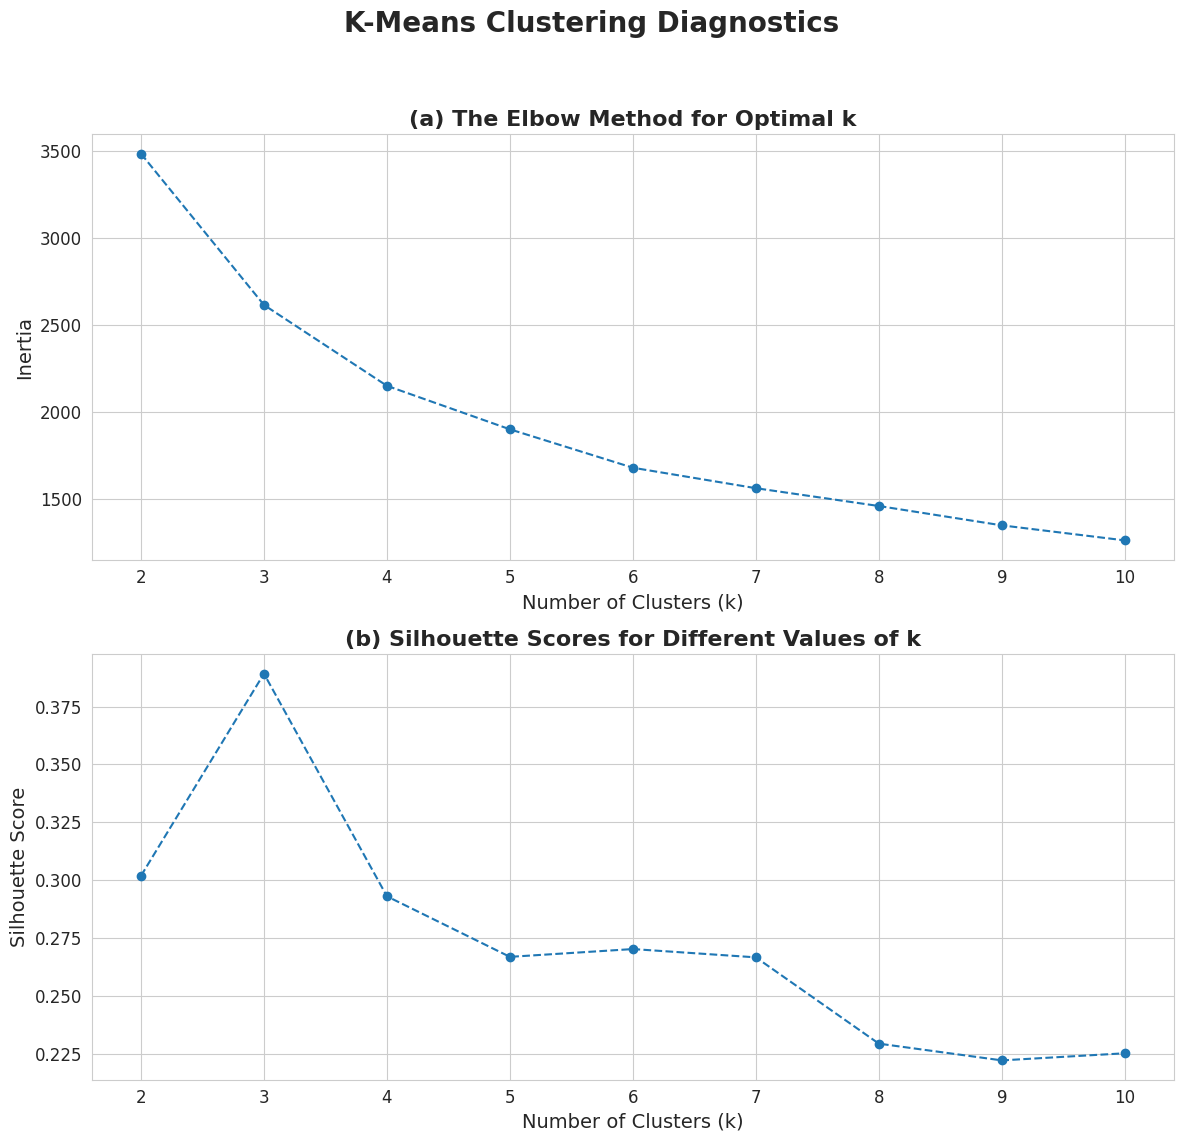

In [5]:
# Determine the Optimal Number of Clusters (k) for K-Means

print("This will test k from 2 to 10 and evaluate using two methods")

# Test a range of clusters from 2 to 10
k_range = range(2, 11)

# These lists will store the results from tests
inertia_values = []
silhouette_scores = []

# This loop will train a new K-Means model for each value of k
for k in k_range:
    print(f"Testing k={k}...")

    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42) # n_init=10 runs the algorithm 10 times and picks the best result, ensures stability
    # random_state=42 ensures same result every time cell is run (reproducibility)

    # Train the model on scaled data
    kmeans.fit(df_scaled)

    # Method 1: The Elbow Method
    # Inertia = sum of squared distances of samples to their closest cluster center
    # Lower inertia is better.
    inertia_values.append(kmeans.inertia_)

    # Method 2: The Silhouette Score
    # The silhouette score measures how similar a data point is to its own cluster compared to other clusters.
    # The score ranges from -1 to 1. A higher score is better.
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

print("\nAll values of k have been tested.")

# Plot results

# 1. Create a figure with two subplots, arranged in 2 rows and 1 column.
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Add a main title for the entire figure.
fig.suptitle('K-Means Clustering Diagnostics', fontsize=20, fontweight='bold')


#  Plot 1: The Elbow Method on the first subplot (axes[0])
axes[0].plot(k_range, inertia_values, marker='o', linestyle='--')
axes[0].set_title('(a) The Elbow Method for Optimal k', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=14)
axes[0].set_ylabel('Inertia', fontsize=14)
axes[0].set_xticks(k_range)
axes[0].grid(True)


#  Plot 2: Silhouette Scores on the second subplot (axes[1])
axes[1].plot(k_range, silhouette_scores, marker='o', linestyle='--')
axes[1].set_title('(b) Silhouette Scores for Different Values of k', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=14)
axes[1].set_ylabel('Silhouette Score', fontsize=14)
axes[1].set_xticks(k_range)
axes[1].grid(True)


# 2. Use tight_layout to automatically adjust spacing and prevent titles/labels from overlapping.
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # The rect argument makes room for the suptitle

# 3. Display the final, combined figure.
plt.show()

Could interpret optimal number (k) of clusters for k-means as either 3 (Silhouette score highest) or 4 (EDA and Elbow Plot suggest). Therefore I am going to compare the two in my training of models below.

In [6]:
# Train and Profile Competing K-Means Models (k=3 and k=4)

# Train the k=3 Model
print("\nTraining K-Means model with k=3...")
kmeans_k3 = KMeans(n_clusters=3, n_init=10, random_state=42)
labels_k3 = kmeans_k3.fit_predict(df_scaled)
print("k=3 model trained.")

# Train the k=4 Model
print("\nTraining K-Means model with k=4...")
kmeans_k4 = KMeans(n_clusters=4, n_init=10, random_state=42)
labels_k4 = kmeans_k4.fit_predict(df_scaled)
print("k=4 model trained.")


# Add Both Sets of Labels to the Original DataFrame
# Create new columns in original 'df' to hold the cluster assignments
# Allows me to profile the clusters using original, unscaled features
df['cluster_k3'] = labels_k3
df['cluster_k4'] = labels_k4
print("\nAdded both sets of cluster labels to the main DataFrame.")


# Profile the Resulting Personas for Both Models
# Generate the two summary tables to inform decision.
# .median() used for more robust to outliers

# Before grouping, create new DataFrame that EXCLUDES the 'LCLid' column
numeric_df = df.drop(columns=['Household_id'])

print("\n Profiling Table for k=3 Model ")
#Group by the k=3 labels and calculate the median for all features
profiling_k3 = numeric_df.groupby('cluster_k3').median()
display(profiling_k3)

print("\n Cluster Sizes for k=3 Model ")
k3_cluster_sizes = df['cluster_k3'].value_counts().sort_index() # .sort_index() ensures the order is 0, 1, 2
print(k3_cluster_sizes)


print("\n Profiling Table for k=4 Model ")
# Same for the k=4 labels
profiling_k4 = numeric_df.groupby('cluster_k4').median()
display(profiling_k4)

print("\n Cluster Sizes for k=4 Model ")
k3_cluster_sizes = df['cluster_k4'].value_counts().sort_index() # .sort_index() ensures the order is 0, 1, 2,3
print(k3_cluster_sizes)


Training K-Means model with k=3...
k=3 model trained.

Training K-Means model with k=4...
k=4 model trained.

Added both sets of cluster labels to the main DataFrame.

 Profiling Table for k=3 Model 


,peak_reduction_weekday,peak_reduction_weekend,load_shift_weekday,peak_reduction_pct_weekday,peak_reduction_pct_weekend,intrinsic_daily_volatility,intrinsic_load_factor,base_peak_to_offpeak_ratio,base_day_to_night_ratio,base_morning_vs_evening_peak_ratio,...,base_weekday_peak,base_weekend_offpeak,base_weekend_peak,trial_weekday_high,trial_weekday_low,trial_weekday_normal,trial_weekend_high,trial_weekend_low,trial_weekend_normal,cluster_k4
cluster_k3,,,,,,,,,,,,,,,,,,,,,
0,0.123638,0.120341,0.022341,39.386132,35.728424,3.696534,0.498490,1.650271,1.474022,0.986376,...,0.337806,0.235666,0.345828,0.195902,0.235903,0.207300,0.205506,0.291234,0.220680,2.0
1,-0.045733,-0.056912,0.040767,-26.207697,-28.860030,3.687166,0.405976,1.202849,1.041750,0.986062,...,0.193413,0.167039,0.191924,0.236717,0.198313,0.201891,0.263765,0.250226,0.216780,1.0
2,0.025007,0.013708,0.006315,13.521563,8.049889,2.087099,0.494098,1.375087,1.185567,1.010870,...,0.189076,0.144531,0.189747,0.160419,0.145822,0.145450,0.170796,0.170535,0.150399,0.0



 Cluster Sizes for k=3 Model 
cluster_k3
0    210
1    120
2    695
Name: count, dtype: int64

 Profiling Table for k=4 Model 


,peak_reduction_weekday,peak_reduction_weekend,load_shift_weekday,peak_reduction_pct_weekday,peak_reduction_pct_weekend,intrinsic_daily_volatility,intrinsic_load_factor,base_peak_to_offpeak_ratio,base_day_to_night_ratio,base_morning_vs_evening_peak_ratio,...,base_weekday_peak,base_weekend_offpeak,base_weekend_peak,trial_weekday_high,trial_weekday_low,trial_weekday_normal,trial_weekend_high,trial_weekend_low,trial_weekend_normal,cluster_k3
cluster_k4,,,,,,,,,,,,,,,,,,,,,
0,0.045408,0.034879,0.009547,21.299415,16.738788,2.275842,0.498576,1.479431,1.272916,1.010084,...,0.216958,0.150324,0.209492,0.160970,0.155692,0.150354,0.164793,0.179504,0.154146,2.0
1,0.000091,-0.014768,0.008723,0.034040,-9.126555,2.144445,0.466307,1.262201,1.094510,1.001464,...,0.172063,0.142211,0.174427,0.170587,0.147724,0.151006,0.184481,0.176251,0.155771,2.0
2,0.168845,0.153648,0.019510,43.190700,41.023216,4.038599,0.500474,1.657161,1.489283,0.987716,...,0.402377,0.257481,0.410275,0.218483,0.267764,0.228672,0.246763,0.338145,0.244857,0.0
3,-0.153474,-0.131397,0.148122,-49.590274,-47.323353,8.234972,0.325609,1.259611,1.127312,1.034089,...,0.303410,0.259925,0.293789,0.475633,0.423791,0.366293,0.432385,0.533984,0.365752,1.0



 Cluster Sizes for k=4 Model 
cluster_k4
0    519
1    351
2    121
3     34
Name: count, dtype: int64


A qualitative analysis of the profiling tables revealed that the 4-cluster solution provided superior explanatory power by successfully isolating the strategically critical 'Engaged Shifter' and 'Contrarian' personas into distinct, high-purity clusters, which were otherwise merged and obscured in the 3-cluster solution.

Now to find optimal number of clusters for the competing method: GMM


Testing covariance type: full...
  Testing n_components=2...
  Testing n_components=3...
  Testing n_components=4...
  Testing n_components=5...
  Testing n_components=6...
  Testing n_components=7...
  Testing n_components=8...
  Testing n_components=9...
  Testing n_components=10...

Testing covariance type: tied...
  Testing n_components=2...
  Testing n_components=3...
  Testing n_components=4...
  Testing n_components=5...
  Testing n_components=6...
  Testing n_components=7...
  Testing n_components=8...
  Testing n_components=9...
  Testing n_components=10...

Testing covariance type: diag...
  Testing n_components=2...
  Testing n_components=3...
  Testing n_components=4...
  Testing n_components=5...
  Testing n_components=6...
  Testing n_components=7...
  Testing n_components=8...
  Testing n_components=9...
  Testing n_components=10...

Testing covariance type: spherical...
  Testing n_components=2...
  Testing n_components=3...
  Testing n_components=4...
  Testing n_comp

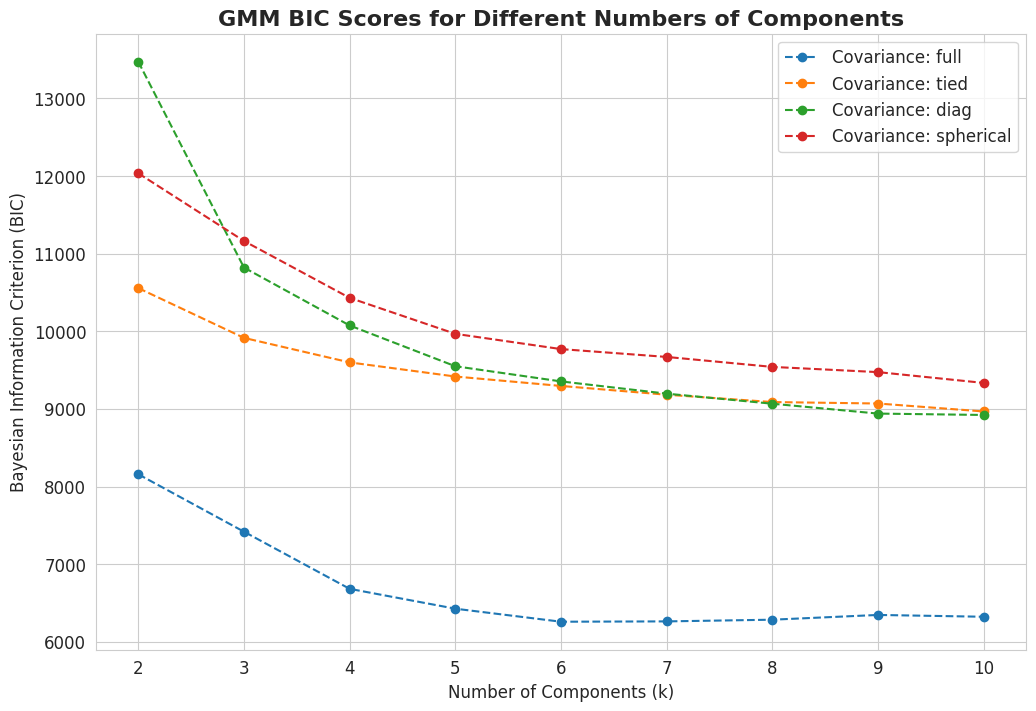

In [7]:
# Determine Optimal Parameters for GMM

# Same scaled data used as K-Means model for a fair comparison

# Define the range of clusters to test
n_components_range = range(2, 11)

# GMM can model different cluster shapes. I'm testing the most common ones.
# 'full': each cluster is a freely oriented ellipse
# 'tied': all clusters share the same orientation
# 'diag': each cluster is an ellipse oriented along the axes
# 'spherical': each cluster is a sphere (similar to K-Means)
covariance_types = ['full', 'tied', 'diag', 'spherical']

# This dictionary will store the BIC scores for each model
bic_scores = {}

# This nested loop will train a GMM for every combination of k and covariance type
for cov_type in covariance_types:
    bic_scores[cov_type] = []
    print(f"\nTesting covariance type: {cov_type}...")
    for n_components in n_components_range:
        print(f"  Testing n_components={n_components}...")

        # Initialize and train the Gaussian Mixture Model
        gmm = GaussianMixture(n_components=n_components,
                              covariance_type=cov_type,
                              n_init=10, # Run 10 times and take the best result
                              random_state=42)

        gmm.fit(df_scaled)

        # Calculate the BIC and append it to our list
        bic_scores[cov_type].append(gmm.bic(df_scaled))

print("\nAll GMM configurations have been tested.")


# Plot the Results
print("\n Bayesian Information Criterion (BIC) Scores ")
plt.figure(figsize=(12, 8))

for cov_type, scores in bic_scores.items():
    plt.plot(n_components_range, scores, marker='o', linestyle='--', label=f'Covariance: {cov_type}')

plt.title('GMM BIC Scores for Different Numbers of Components', fontsize=16, fontweight='bold')
plt.xlabel('Number of Components (k)', fontsize=12)
plt.ylabel('Bayesian Information Criterion (BIC)', fontsize=12)
plt.xticks(n_components_range)
plt.legend()
plt.grid(True)
plt.show()

# line and point that has the LOWEST BIC score: The number of components (k) at the lowest point of the best line is optimal choice for GMM

So the optimal number (k) for GMM is k = 6 (lowest point on lowest line). This will be compared to k = 4 from k-means to find the optimal clustering algorithm

In [10]:
# Set the display option to show all columns for the rest of this notebook session
pd.set_option('display.max_columns', None)
# Lets me view all of the columns for k=3 vs k=4 comparison, before vital middle columns
# were not included

In [11]:
# Final Model Comparison and Selection

# Compare K-Means (k=4) against GMM (k=6)

# Train the Final K-Means Model
print("\nTraining final K-Means model (k=4)")
kmeans_final = KMeans(n_clusters=4, n_init=10, random_state=42)
kmeans_labels = kmeans_final.fit_predict(df_scaled)
print("K-Means model trained.")


# Train the Final GMM
print("\nTraining final GMM (k=6, covariance='full')")
gmm_final = GaussianMixture(n_components=6, # UPDATED FROM 4
                            covariance_type='full',
                            n_init=10,
                            random_state=42)

gmm_labels = gmm_final.fit_predict(df_scaled)
print("GMM trained.")


# The Head-to-Head Comparison
print("\n Model Comparison using Silhouette Score ")
kmeans_silhouette = silhouette_score(df_scaled, kmeans_labels)
print(f"Silhouette Score for K-Means (k=4): {kmeans_silhouette:.4f}")
gmm_silhouette = silhouette_score(df_scaled, gmm_labels)
print(f"Silhouette Score for GMM (k=6): {gmm_silhouette:.4f}") # Corrected label

# Model selection logic
if kmeans_silhouette >= gmm_silhouette:
    print("\nThe K-Means (k=4) model has the higher Silhouette Score.")
    print("This model is recommended for its high score and superior interpretability.")
    final_cluster_labels = kmeans_labels
else:
    print("\nThe GMM (k=6) model has the higher Silhouette Score.")
    print("While statistically superior, consider if interpreting 6 clusters aligns with the project's strategic goals.")
    final_cluster_labels = gmm_labels

# Add the winning labels to original DataFrame for profiling
df['final_cluster_label'] = final_cluster_labels
print(f"\nAdded the winning labels to the main DataFrame.")


Training final K-Means model (k=4)
K-Means model trained.

Training final GMM (k=6, covariance='full')
GMM trained.

 Model Comparison using Silhouette Score 
Silhouette Score for K-Means (k=4): 0.2930
Silhouette Score for GMM (k=6): -0.0330

The K-Means (k=4) model has the higher Silhouette Score.
This model is recommended for its high score and superior interpretability.

Added the winning labels to the main DataFrame.


k-means has the far higher Silhouette score therefore I selected the k-means (k=4) model

In [12]:
# Train the Definitive Model: K-Means with k=4
# Using'final_cluster_label' from the previous cell
print("\n Generating Final Persona Profiles from the chosen K-Means (k=4) model ")


# Create  Master List of Feature Columns
# This list explicitly defines the 23 features for analysis
# Using the clean names I defined in cell 2!
final_feature_columns = [
    'base_weekday_offpeak', 'base_weekday_peak', 'base_weekend_offpeak', 'base_weekend_peak',
    'trial_weekday_high', 'trial_weekday_low', 'trial_weekday_normal', 'trial_weekend_high',
    'trial_weekend_low', 'trial_weekend_normal', 'intrinsic_daily_volatility',
    'intrinsic_load_factor', 'base_peak_to_offpeak_ratio', 'base_day_to_night_ratio',
    'base_morning_vs_evening_peak_ratio', 'peak_reduction_weekday', 'peak_reduction_weekend',
    'peak_reduction_pct_weekday', 'peak_reduction_pct_weekend', 'load_shift_weekday',
    'estimated_cost_savings_pct', 'economic_rationality_score'
]

# Generate the Definitive Profiling Tables

print("\n Definitive Persona Profiling Table (Median Values)")

# Group by 'final_cluster_label'
persona_profile = df.groupby('final_cluster_label')[final_feature_columns].median()
persona_profile['size'] = df['final_cluster_label'].value_counts()
cols_order = ['size'] + final_feature_columns
persona_profile = persona_profile[cols_order]
display(persona_profile)


print("\n Persona Profile vs. Cohort Median (Ratio)")

cohort_median = df[final_feature_columns].median()
profile_for_division = persona_profile[final_feature_columns]
epsilon = 1e-6
profile_vs_average = profile_for_division / (cohort_median + epsilon)
profile_vs_average['size'] = persona_profile['size']
profile_vs_average = profile_vs_average[cols_order]
display(profile_vs_average)


# Create the Final, Clean DataFrame for Export
print("\n Creating Final, Cleaned DataFrame for Export ")
# First, create a clean 'persona' column from the cluster labels for the final export
df['persona'] = df['final_cluster_label']
# Define the definitive list of columns for final dataset
final_columns_to_export = ['Household_id', 'persona'] + final_feature_columns
df_final_export = df[final_columns_to_export].copy()
print(f"Final dataset created with {df_final_export.shape[1]} columns.")
display(df_final_export.head())


# Save the Final, Cleaned Dataset to a CSV File
# Define a clear filename
output_directory = '/content/drive/MyDrive/ERP/data_loaded/'
# Save to a new, versioned filename
final_csv_path = os.path.join(output_directory, 'final_persona_dataset_v2_cleaned.csv')
df_final_export.to_csv(final_csv_path, index=False)

pd.set_option('display.max_columns', None)
print(f"\nFinal dataset with clean names successfully saved to:")
print(final_csv_path)


 Generating Final Persona Profiles from the chosen K-Means (k=4) model 

 Definitive Persona Profiling Table (Median Values)


,size,base_weekday_offpeak,base_weekday_peak,base_weekend_offpeak,base_weekend_peak,trial_weekday_high,trial_weekday_low,trial_weekday_normal,trial_weekend_high,trial_weekend_low,trial_weekend_normal,intrinsic_daily_volatility,intrinsic_load_factor,base_peak_to_offpeak_ratio,base_day_to_night_ratio,base_morning_vs_evening_peak_ratio,peak_reduction_weekday,peak_reduction_weekend,peak_reduction_pct_weekday,peak_reduction_pct_weekend,load_shift_weekday,estimated_cost_savings_pct,economic_rationality_score
final_cluster_label,,,,,,,,,,,,,,,,,,,,,,,
0,519,0.141972,0.216958,0.150324,0.209492,0.160970,0.155692,0.150354,0.164793,0.179504,0.154146,2.275842,0.498576,1.479431,1.272916,1.010084,0.045408,0.034879,21.299415,16.738788,0.009547,4.272328,1.863710
1,351,0.132993,0.172063,0.142211,0.174427,0.170587,0.147724,0.151006,0.184481,0.176251,0.155771,2.144445,0.466307,1.262201,1.094510,1.001464,0.000091,-0.014768,0.034040,-9.126555,0.008723,3.082793,1.690402
2,121,0.225092,0.402377,0.257481,0.410275,0.218483,0.267764,0.228672,0.246763,0.338145,0.244857,4.038599,0.500474,1.657161,1.489283,0.987716,0.168845,0.153648,43.190700,41.023216,0.019510,6.700839,2.355001
3,34,0.252523,0.303410,0.259925,0.293789,0.475633,0.423791,0.366293,0.432385,0.533984,0.365752,8.234972,0.325609,1.259611,1.127312,1.034089,-0.153474,-0.131397,-49.590274,-47.323353,0.148122,1.951627,1.728003



 Persona Profile vs. Cohort Median (Ratio)


,size,base_weekday_offpeak,base_weekday_peak,base_weekend_offpeak,base_weekend_peak,trial_weekday_high,trial_weekday_low,trial_weekday_normal,trial_weekend_high,trial_weekend_low,trial_weekend_normal,intrinsic_daily_volatility,intrinsic_load_factor,base_peak_to_offpeak_ratio,base_day_to_night_ratio,base_morning_vs_evening_peak_ratio,peak_reduction_weekday,peak_reduction_weekend,peak_reduction_pct_weekday,peak_reduction_pct_weekend,load_shift_weekday,estimated_cost_savings_pct,economic_rationality_score
final_cluster_label,,,,,,,,,,,,,,,,,,,,,,,
0,519,0.944275,0.997581,0.951171,0.982424,0.932919,0.928675,0.926967,0.899482,0.915313,0.925148,0.927015,1.025267,1.050326,1.052640,1.005899,1.538803,1.867760,1.368110,1.589372,0.839595,1.088830,1.033460
1,351,0.884554,0.791154,0.899834,0.817982,0.988655,0.881147,0.930988,1.006949,0.898723,0.934895,0.873493,0.958909,0.896103,0.905107,0.997315,0.003068,-0.790825,0.002186,-0.866580,0.767193,0.785669,0.937358
2,121,1.497113,1.850145,1.629205,1.924004,1.266240,1.597169,1.409816,1.346898,1.724240,1.469571,1.645035,1.029170,1.176506,1.231565,0.983624,5.721936,8.227718,2.774237,3.895214,1.715824,1.707751,1.305890
3,34,1.679561,1.395094,1.644670,1.377739,2.756578,2.527842,2.258283,2.360073,2.722846,2.195153,3.354336,0.669578,0.894264,0.932233,1.029805,-5.201036,-7.036189,-3.185296,-4.493421,13.026751,0.497385,0.958208



 Creating Final, Cleaned DataFrame for Export 
Final dataset created with 24 columns.


,Household_id,persona,base_weekday_offpeak,base_weekday_peak,base_weekend_offpeak,base_weekend_peak,trial_weekday_high,trial_weekday_low,trial_weekday_normal,trial_weekend_high,trial_weekend_low,trial_weekend_normal,intrinsic_daily_volatility,intrinsic_load_factor,base_peak_to_offpeak_ratio,base_day_to_night_ratio,base_morning_vs_evening_peak_ratio,peak_reduction_weekday,peak_reduction_weekend,peak_reduction_pct_weekday,peak_reduction_pct_weekend,load_shift_weekday,estimated_cost_savings_pct,economic_rationality_score
0,D0000,1,0.111965,0.170274,0.124892,0.159840,0.156928,0.139553,0.127799,0.162200,0.183983,0.140118,1.719578,0.528509,1.520769,1.201120,1.065270,0.010094,-0.005836,5.928131,-3.651439,0.025642,2.820188,1.821489
1,D0001,1,0.094870,0.120213,0.093057,0.111972,0.110911,0.099488,0.106971,0.117738,0.102677,0.108033,1.408479,0.496033,1.267128,1.027525,1.073594,0.006051,-0.009243,5.033200,-8.254847,0.002672,4.254401,1.721271
2,D0002,2,0.300737,0.600204,0.450773,0.699630,0.492804,0.368057,0.380374,0.531078,0.522850,0.413935,8.111155,0.420619,1.995773,1.762536,0.857887,0.104148,0.165076,17.352084,23.594709,0.065374,0.805475,1.532046
3,D0003,0,0.197064,0.158431,0.231493,0.151456,0.099487,0.232186,0.180412,0.104167,0.272749,0.216271,1.463273,0.449315,0.803954,0.692284,1.046047,0.055692,0.043813,35.151939,28.927676,0.033175,14.243653,4.597324
4,D0004,0,0.096884,0.260018,0.099851,0.191437,0.142943,0.103491,0.110439,0.130448,0.106318,0.099826,1.450504,0.619237,2.683792,1.202150,1.358235,0.113824,0.057513,43.775144,30.042499,0.004660,0.590977,1.443967



Final dataset with clean names successfully saved to:
/content/drive/MyDrive/ERP/data_loaded/final_persona_dataset_v2_cleaned.csv


Penultimately I will try and visualise the clusters using PCA to output a 2D graph (5 dimensional visualisation for my 5 responsiveness features would be far too complex to comprehend)

Using PCA to reduce the 5-dimensional feature space to 2 dimensions for plotting
PCA complete. Explained variance by PC1: 0.66
Explained variance by PC2: 0.19


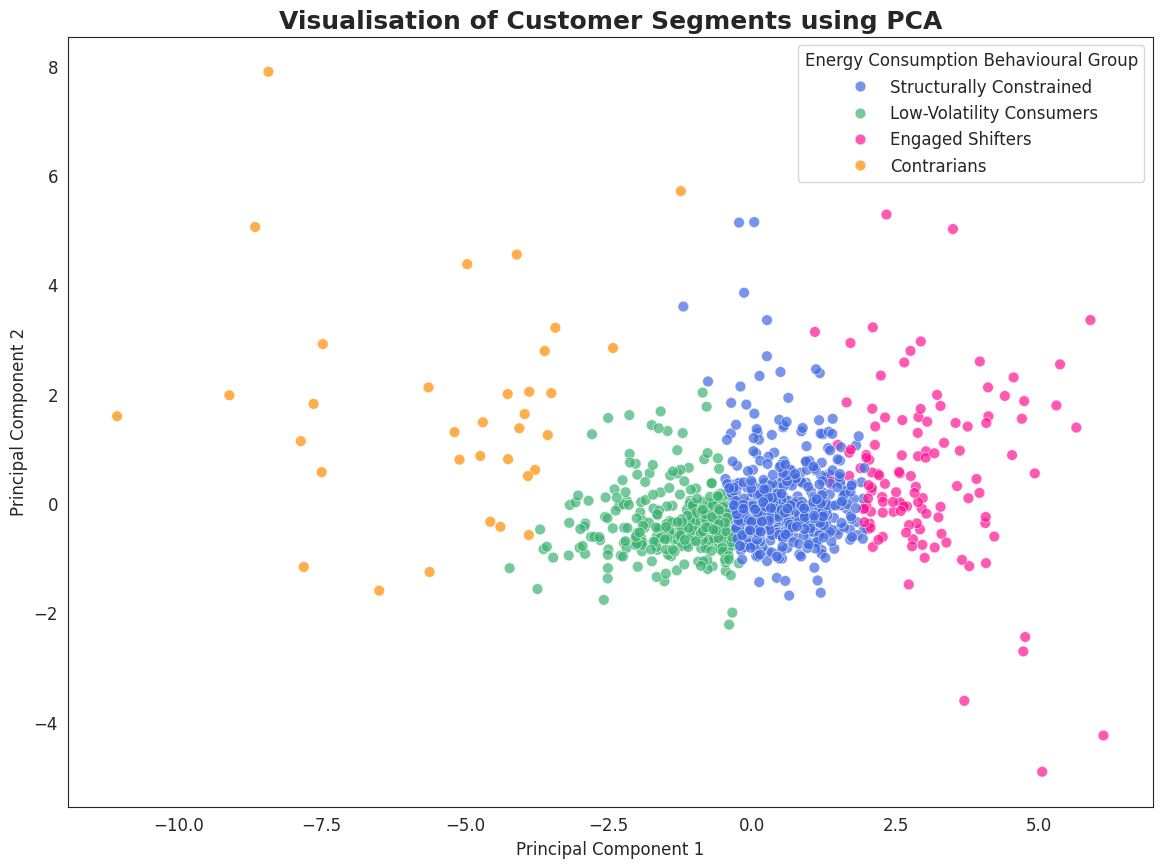

In [13]:
# Visualise Clusters Using PCA

from sklearn.decomposition import PCA

print("Using PCA to reduce the 5-dimensional feature space to 2 dimensions for plotting")

# Apply PCA
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(df_scaled)

# Create a new DataFrame with the PCA results
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['persona'] = df_final_export['persona'] # This uses the final cluster numbers

print(f"PCA complete. Explained variance by PC1: {pca.explained_variance_ratio_[0]:.2f}")
print(f"Explained variance by PC2: {pca.explained_variance_ratio_[1]:.2f}")


#perona map to reflect the clusters I just found
persona_map = {
    0: 'Structurally Constrained',
    1: 'Low-Volatility Consumers',
    2: 'Engaged Shifters',
    3: 'Contrarians'
}
df_pca['persona_name'] = df_pca['persona'].map(persona_map)


# The high-contrast palette maps to the names, done for ease of interpretation
custom_palette = {
    'Engaged Shifters':         'deeppink',
    'Structurally Constrained': 'royalblue',
    'Low-Volatility Consumers': 'mediumseagreen',
    'Contrarians':              'darkorange'
}

#Set plot style to 'white' to remove grid lines for a cleaner look
sns.set_style('white')

plt.figure(figsize=(14, 10))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='persona_name',
    hue_order=list(persona_map.values()), # Ensure consistent legend order
    palette=custom_palette,
    data=df_pca,
    alpha=0.7,
    s=60,
    edgecolor='white',
    linewidth=0.5
)

#Titles
plt.title('Visualisation of Customer Segments using PCA', fontsize=18, fontweight='bold')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Energy Consumption Behavioural Group')

plt.show()

# Set the style back to whitegrid for subsequent plots
sns.set_style('whitegrid')

Stage 8: Creating Final, Publication-Quality Persona Profiles


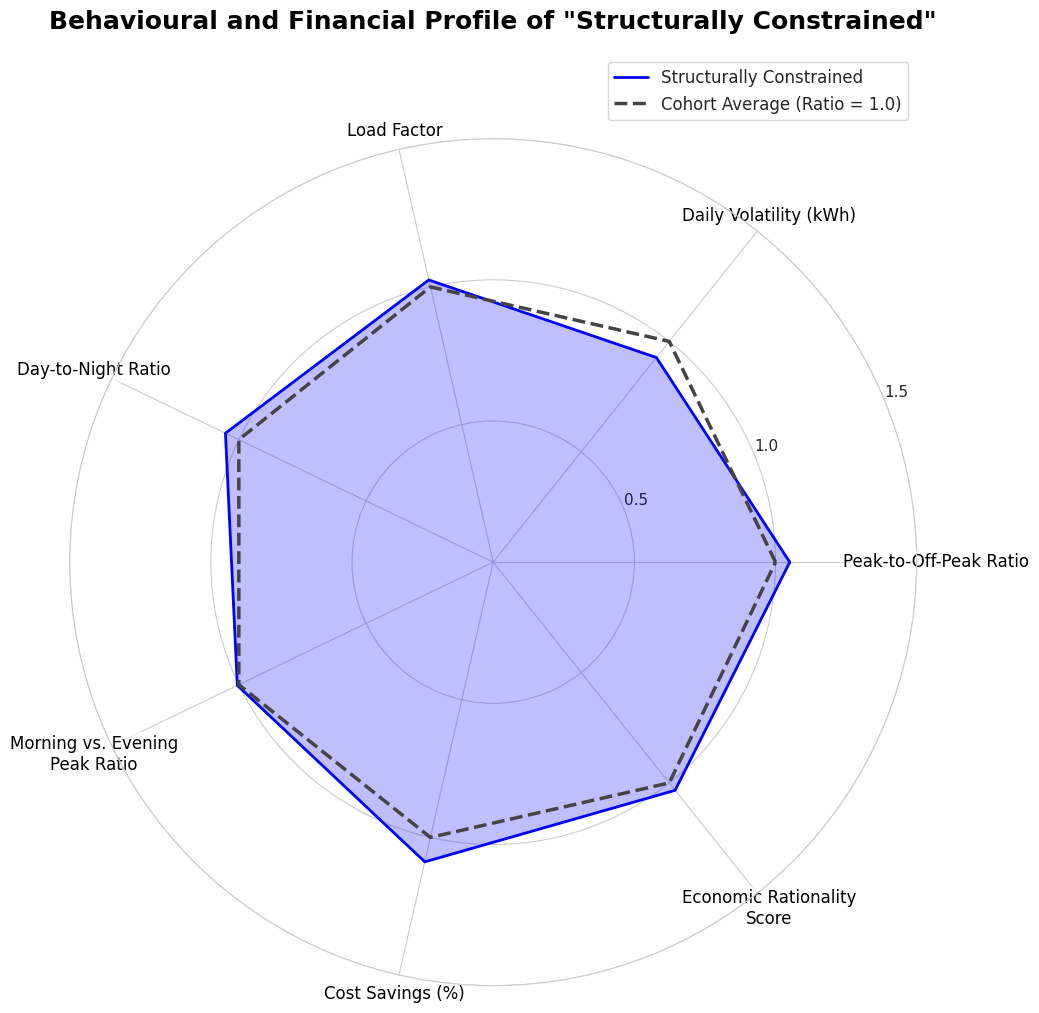

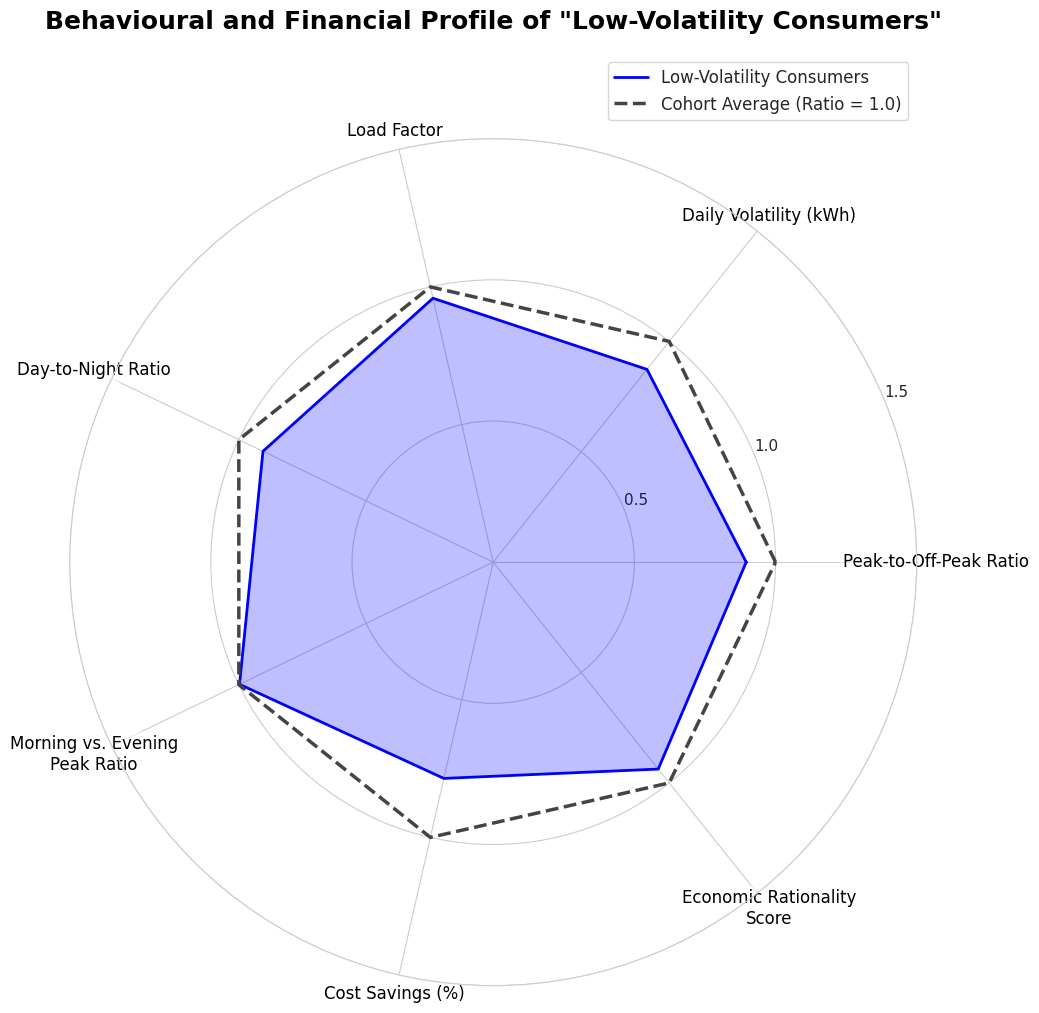

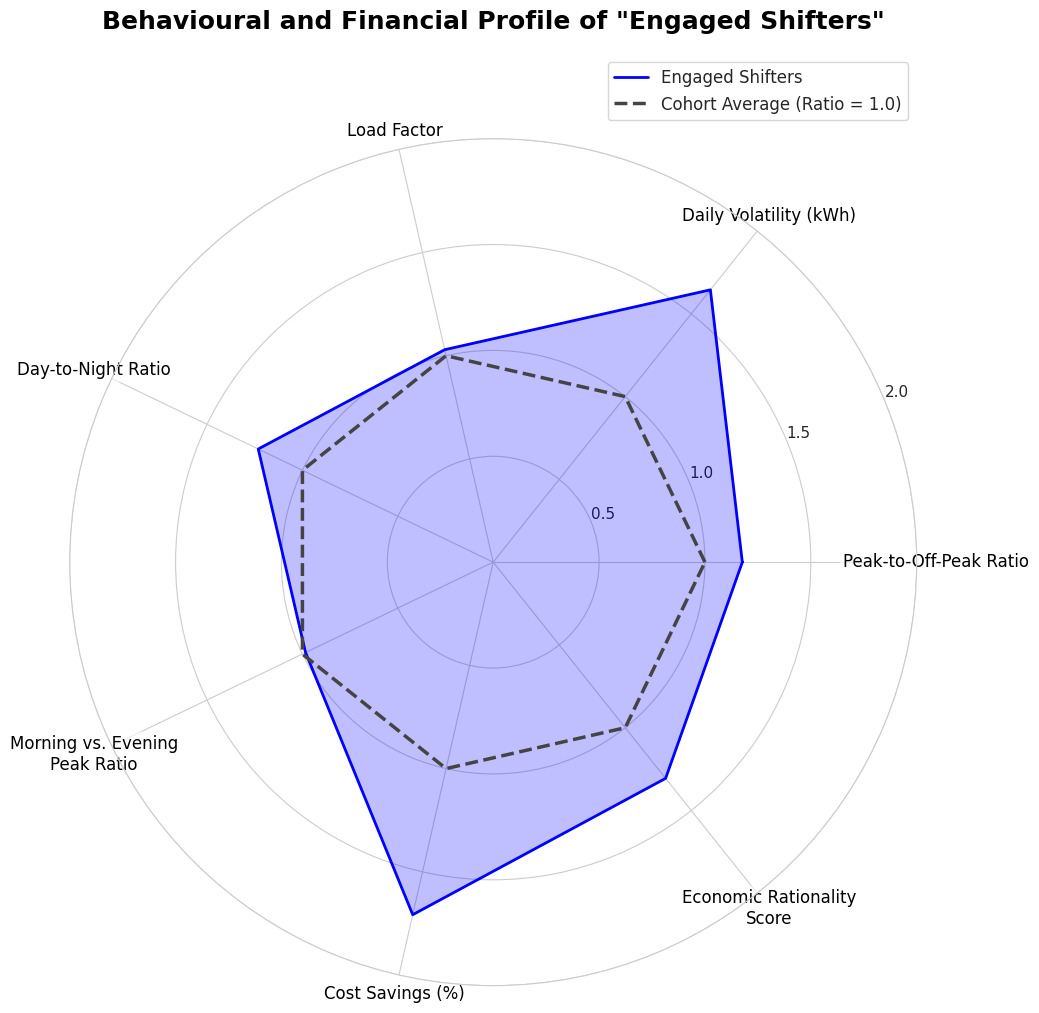

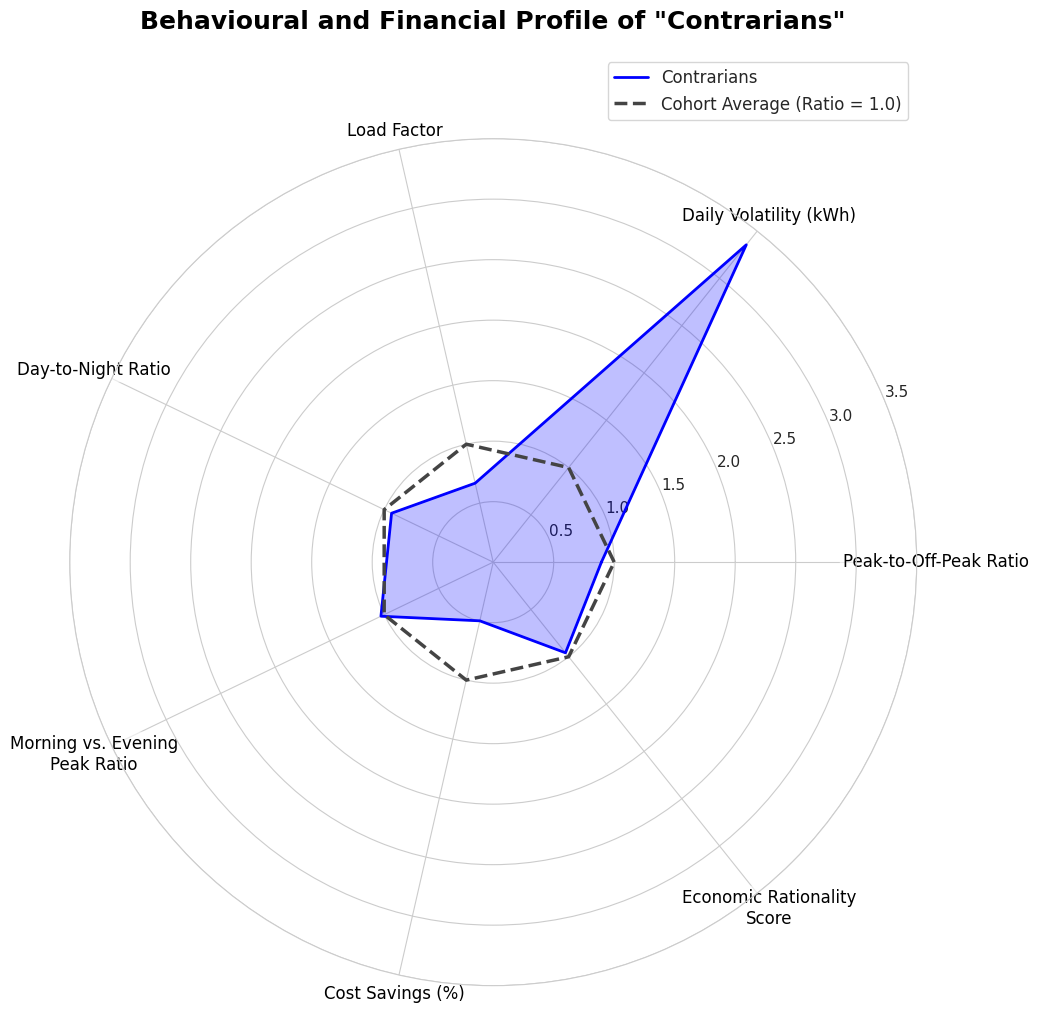

In [14]:
#I'm creating radar maps to visualise how each beahvioural cluster varies and compares to the median

import textwrap
import math

print("Stage 8: Creating Final, Publication-Quality Persona Profiles")

#  Prepare Data and Labels for Radar Charts

persona_map = {
    0: 'Structurally Constrained',
    1: 'Low-Volatility Consumers',
    2: 'Engaged Shifters',
    3: 'Contrarians'
}

feature_labels_with_units = {
    'base_peak_to_offpeak_ratio': 'Peak-to-Off-Peak Ratio',
    'intrinsic_daily_volatility': 'Daily Volatility (kWh)',
    'intrinsic_load_factor': 'Load Factor',
    'base_day_to_night_ratio': 'Day-to-Night Ratio',
    'base_morning_vs_evening_peak_ratio': 'Morning vs. Evening\nPeak Ratio',
    'estimated_cost_savings_pct': 'Cost Savings (%)',
    'economic_rationality_score': 'Economic Rationality\nScore'
}
radar_features = list(feature_labels_with_units.keys())
clean_labels = list(feature_labels_with_units.values())

# Pull the data from the 'profile_vs_average' table from earlier
profile_for_radar = profile_vs_average[radar_features].copy()
average_household = pd.Series([1.0] * len(radar_features), index=radar_features)


# Create the Radar Charts in a Loop (efficient)
for i in sorted(profile_for_radar.index):
    persona_name = persona_map[i]
    persona_data = profile_for_radar.loc[i]

    labels = np.array(clean_labels)
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(11, 11), subplot_kw=dict(polar=True))

    persona_values = persona_data.values.flatten().tolist()
    persona_values += persona_values[:1]
    ax.plot(angles, persona_values, color='blue', linewidth=2, label=persona_name, zorder=3)
    ax.fill(angles, persona_values, color='blue', alpha=0.25, zorder=3)

    avg_values = average_household.values.flatten().tolist()
    avg_values += avg_values[:1]
    ax.plot(angles, avg_values, color='#444444', linestyle='--', linewidth=2.5, label='Cohort Average (Ratio = 1.0)', zorder=4)

    max_val = persona_data.max()
    plot_max = math.ceil(max_val * 2) / 2 if max_val > 1.5 else 1.5
    rticks = np.arange(0.5, plot_max + 0.5, 0.5)
    rtick_labels = [f"{tick:.1f}" for tick in rticks]
    ax.set_rgrids(rticks, labels=rtick_labels, angle=22.5, size=11)
    ax.set_ylim(0, plot_max)

    label_bbox_props = dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.6)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, size=12, color='black', bbox=label_bbox_props)

    plt.title(f'Behavioural and Financial Profile of "{persona_name}"',
              size=18, color='black', y=1.12, fontweight='bold')
    plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.1))
    plt.show()
    print("\n" + "="*80 + "\n") #nice separation line, makes it easier for me to quickly distinguish between my plots

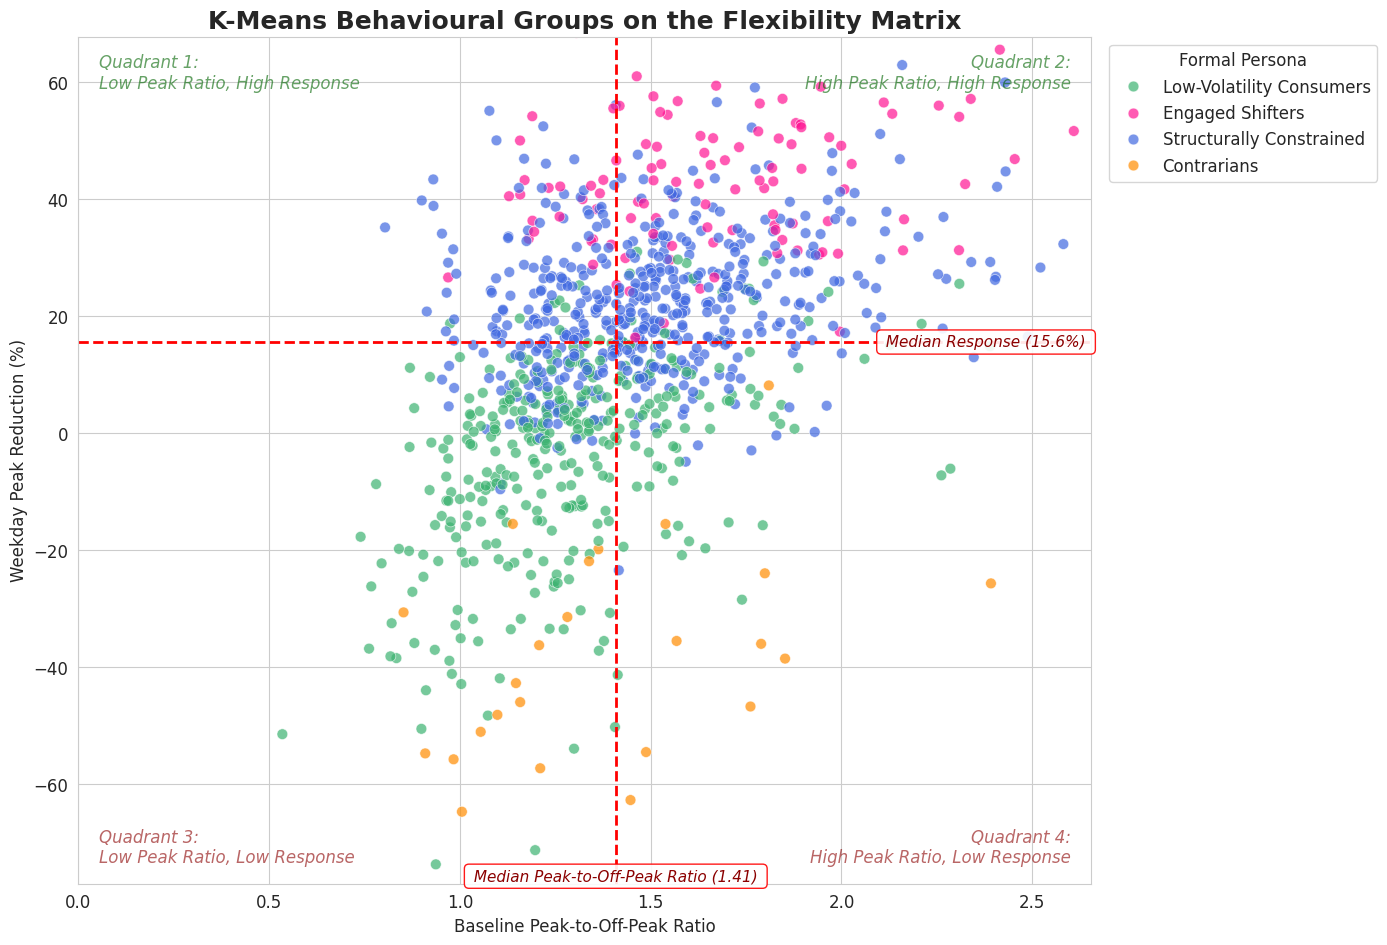

In [16]:
# Validation: Using earlier EDA flexibility matrix but assigning clusters based on their behavioural group

# Define the two key axes
x_feature = 'base_peak_to_offpeak_ratio'
y_feature = 'peak_reduction_pct_weekday'

persona_map = {
    0: 'Structurally Constrained',
    1: 'Low-Volatility Consumers',
    2: 'Engaged Shifters',
    3: 'Contrarians'
}
color_map = {
    'Engaged Shifters':         'deeppink',
    'Structurally Constrained': 'royalblue',
    'Low-Volatility Consumers': 'mediumseagreen',
    'Contrarians':              'darkorange'
}

# This line now uses the updated map to create the persona_name column
df_final_export['persona_name'] = df_final_export['persona'].map(persona_map)


# Create the Plot using Subplots
fig, ax = plt.subplots(figsize=(15, 11))

sns.scatterplot(
    data=df_final_export,
    x=x_feature,
    y=y_feature,
    hue='persona_name',
    palette=color_map, # This now uses your updated color map
    alpha=0.7,
    s=60,
    edgecolor='white',
    linewidth=0.5,
    ax=ax
)

# Add Median Lines
x_median = df_final_export[x_feature].median()
y_median = df_final_export[y_feature].median()
ax.axvline(x_median, color='red', linestyle='--', linewidth=2)
ax.axhline(y_median, color='red', linestyle='--', linewidth=2)


# Quadrant Labels
persona_font = {'fontsize': 12, 'style': 'italic'}
ax.text(0.98, 0.98, 'Quadrant 2:\nHigh Peak Ratio, High Response', transform=ax.transAxes, color='darkgreen', va='top', ha='right', alpha=0.6, **persona_font)
ax.text(0.98, 0.02, 'Quadrant 4:\nHigh Peak Ratio, Low Response', transform=ax.transAxes, color='darkred', va='bottom', ha='right', alpha=0.6, **persona_font)
ax.text(0.02, 0.98, 'Quadrant 1:\nLow Peak Ratio, High Response', transform=ax.transAxes, color='darkgreen', va='top', ha='left', alpha=0.6, **persona_font)
ax.text(0.02, 0.02, 'Quadrant 3:\nLow Peak Ratio, Low Response', transform=ax.transAxes, color='darkred', va='bottom', ha='left', alpha=0.6, **persona_font)


# Final Formatting
ax.set_title('K-Means Behavioural Groups on the Flexibility Matrix', fontsize=18, fontweight='bold')
ax.set_xlabel(f'Baseline Peak-to-Off-Peak Ratio', fontsize=12)
ax.set_ylabel('Weekday Peak Reduction (%)', fontsize=12)
ax.legend(title='Formal Persona', loc='upper left', bbox_to_anchor=(1.01, 1.0))

# Set the plot limits FIRST
ax.set_xlim(0, df_final_export[x_feature].quantile(0.99))
ax.set_ylim(df_final_export[y_feature].quantile(0.01), df_final_export[y_feature].quantile(0.99))

# Using limits set correct coordinates for labels of the media
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1, alpha=0.9)

ax.text(ax.get_xlim()[1], y_median, f' Median Response ({y_median:.1f}%) ',
        color='darkred', ha='right', va='center', fontsize=11, style='italic', bbox=bbox_props)

ax.text(x_median, ax.get_ylim()[0], f' Median Peak-to-Off-Peak Ratio ({x_median:.2f}) ',
        color='darkred', ha='center', va='bottom', fontsize=11, style='italic', bbox=bbox_props)

# Manual layout adjustment to make space for the legend
fig.subplots_adjust(right=0.8)

plt.show()

In [17]:
# Quantitative Validation of the Flexibility Matrix

# Define the Quadrants Programmatically
# Create new columns in final DataFrame to identify which quadrant each household falls into
#This is great for my report - quantitative proof of segmentation being distinct

# Get the median values that define the lines
x_median = df_final_export['base_peak_to_offpeak_ratio'].median()
y_median = df_final_export['peak_reduction_pct_weekday'].median()

# Define the conditions for each quadrant
is_top = df_final_export['peak_reduction_pct_weekday'] >= y_median
is_right = df_final_export['base_peak_to_offpeak_ratio'] >= x_median

# Assign each household to a quadrant
conditions = [
    (is_top) & (is_right),    # Top-Right
    (is_top) & (~is_right),   # Top-Left
    (~is_top) & (is_right),   # Bottom-Right
    (~is_top) & (~is_right)    # Bottom-Left
]

#List matches conditions above
quadrant_names = [
    'Q2: High Peak Ratio, High Response',  # Corresponds to Top-Right
    'Q1: Low Peak Ratio, High Response',   # Corresponds to Top-Left
    'Q4: High Peak Ratio, Low Response',    # Corresponds to Bottom-Right
    'Q3: Low Peak Ratio, Low Response'     # Corresponds to Bottom-Left
]

df_final_export['quadrant'] = np.select(conditions, quadrant_names, default='Unknown')


# Create the Contingency Tables using quadrant names

print("\nRaw Count of Personas in Each Quadrant")
# pd.crosstab creates a frequency table.
contingency_table = pd.crosstab(df_final_export['persona_name'], df_final_export['quadrant'])
# Re-order columns for intuitive reading (Q1, Q2, Q3, Q4)
contingency_table = contingency_table[['Q1: Low Peak Ratio, High Response', 'Q2: High Peak Ratio, High Response', 'Q3: Low Peak Ratio, Low Response', 'Q4: High Peak Ratio, Low Response']]
display(contingency_table)


print("\nPercentage of Each Persona in Each Quadrant (%)")
# The normalize="index" argument shows, for each persona, the percentage distribution across the quadrants.
contingency_pct = pd.crosstab(df_final_export['persona_name'], df_final_export['quadrant'], normalize='index') * 100
# Re-order columns to match the table above
contingency_pct = contingency_pct[['Q1: Low Peak Ratio, High Response', 'Q2: High Peak Ratio, High Response', 'Q3: Low Peak Ratio, Low Response', 'Q4: High Peak Ratio, Low Response']]
display(contingency_pct.style.format('{:.1f}%').background_gradient(cmap='Greens'))


Raw Count of Personas in Each Quadrant


quadrant,"Q1: Low Peak Ratio, High Response","Q2: High Peak Ratio, High Response","Q3: Low Peak Ratio, Low Response","Q4: High Peak Ratio, Low Response"
persona_name,,,,
Contrarians,0,0,22,12
Engaged Shifters,26,95,0,0
Low-Volatility Consumers,8,18,249,76
Structurally Constrained,122,244,85,68



Percentage of Each Persona in Each Quadrant (%)


quadrant,"Q1: Low Peak Ratio, High Response","Q2: High Peak Ratio, High Response","Q3: Low Peak Ratio, Low Response","Q4: High Peak Ratio, Low Response"
persona_name,,,,
Contrarians,0.0%,0.0%,64.7%,35.3%
Engaged Shifters,21.5%,78.5%,0.0%,0.0%
Low-Volatility Consumers,2.3%,5.1%,70.9%,21.7%
Structurally Constrained,23.5%,47.0%,16.4%,13.1%
